In [4]:
import pandas as pd
import numpy as np
import sys, os
import sscapi

In [5]:
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
# Define the lat, long of the location and the year
lat, lon, year = 33.2164, -97.1292, 2010
# You must request an NSRDB api key from the link above
api_key = 'Mow538glfN0fjR9Sk9RFqnnhuUDm5lxZBcTTqeKK'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp,solar_zenith_angle'
# Choose year of data
year = '2010'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '30'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'Zihao+Tao'
# Your reason for using the NSRDB.
reason_for_use = 'beta+testing'
# Your affiliation
your_affiliation = 'university+of+washington'
# Your email address
your_email = 'taozihao@uw.edu'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'true'

# Declare url string
url = 'http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
# Return just the first 2 lines to get metadata:
info = pd.read_csv(url, nrows=1)
# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = info['Local Time Zone'], info['Elevation']

In [6]:
# View metadata
info

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,...,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Version
0,NSRDB,680780,-,-,-,33.21,-97.14,-6,203,-6,...,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,v2.0.1


In [7]:
# Return all but first 2 lines of csv to get data:
df = pd.read_csv('http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)

# Set the time index in the pandas dataframe:
df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

# take a look
print ('shape:',df.shape)
df.head()

shape: (17520, 11)


,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
2010-01-01 00:00:00,2010,1,1,0,0,0,0,0,3.594724,-2.604285,167.605189
2010-01-01 00:30:00,2010,1,1,0,30,0,0,0,3.414035,-2.867499,169.785147
2010-01-01 01:00:00,2010,1,1,1,0,0,0,0,3.233346,-3.130713,168.080732
2010-01-01 01:30:00,2010,1,1,1,30,0,0,0,3.114784,-3.304114,163.670063
2010-01-01 02:00:00,2010,1,1,2,0,0,0,0,2.996223,-3.477515,158.144707


In [8]:
# Print column names
print (df.columns.values)

['Year' 'Month' 'Day' 'Hour' 'Minute' 'GHI' 'DHI' 'DNI' 'Wind Speed'
 'Temperature' 'Solar Zenith Angle']


In [17]:
ssc = sscapi.PySSC()

# Resource inputs for SAM model:
wfd = ssc.data_create()
ssc.data_set_number(wfd, b'lat', lat)
ssc.data_set_number(wfd, b'lon', lon)
ssc.data_set_number(wfd, b'tz', timezone)
ssc.data_set_number(wfd, b'elev', elevation)
ssc.data_set_array(wfd, b'year', df.index.year)
ssc.data_set_array(wfd, b'month', df.index.month)
ssc.data_set_array(wfd, b'day', df.index.day)
ssc.data_set_array(wfd, b'hour', df.index.hour)
ssc.data_set_array(wfd, b'minute', df.index.minute)
ssc.data_set_array(wfd, b'dn', df['DNI'])
ssc.data_set_array(wfd, b'df', df['DHI'])
ssc.data_set_array(wfd, b'wspd', df['Wind Speed'])
ssc.data_set_array(wfd, b'tdry', df['Temperature'])

# Create SAM compliant object  
dat = ssc.data_create()
ssc.data_set_table(dat, b'solar_resource_data', wfd)
ssc.data_free(wfd)

# Specify the system Configuration
# Set system capacity in MW
system_capacity = 4
ssc.data_set_number(dat, b'system_capacity', system_capacity)
# Set DC/AC ratio (or power ratio). See https://sam.nrel.gov/sites/default/files/content/virtual_conf_july_2013/07-sam-virtual-conference-2013-woodcock.pdf
ssc.data_set_number(dat, b'dc_ac_ratio', 1.1)
# Set tilt of system in degrees
ssc.data_set_number(dat, b'tilt', 25)
# Set azimuth angle (in degrees) from north (0 degrees)
ssc.data_set_number(dat, b'azimuth', 180)
# Set the inverter efficency
ssc.data_set_number(dat, b'inv_eff', 96)
# Set the system losses, in percent
ssc.data_set_number(dat, b'losses', 14.0757)
# Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
ssc.data_set_number(dat, b'array_type', 0)
# Set ground coverage ratio
ssc.data_set_number(dat, b'gcr', 0.4)
# Set constant loss adjustment
ssc.data_set_number(dat, b'adjust:constant', 0)

# execute and put generation results back into dataframe
mod = ssc.module_create(b'pvwattsv5')
ssc.module_exec(mod, dat)
df['generation'] = np.array(ssc.data_get_array(dat, b'gen'))

# free the memory
ssc.data_free(dat)
ssc.module_free(mod)

In [20]:
# Divide sum of generation by the number of periods times the system size
df['generation'].sum() / (525600/int(interval) * system_capacity)

0.1734957673203906

In [21]:
# Total Energy:
df['generation'].sum()

12158.583373812973

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def nsrdb_plot(df, i):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df['90 Degree Zenith'] = 90
    df[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle', '90 Degree Zenith']][i:i+int(interval)].plot(ax=ax, figsize=(15,8), yticks=(np.arange(0,900,100)), style={'90 Degree Zenith': '--','Solar Zenith Angle': '-o', 'DNI': '-o', 'DHI': '-o', 'GHI': '-o'}, legend=False)
    df['generation'][i:i+30].plot(ax=ax2, yticks=(np.arange(0,4.5,0.5)), style={'generation': 'y-o'})
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)

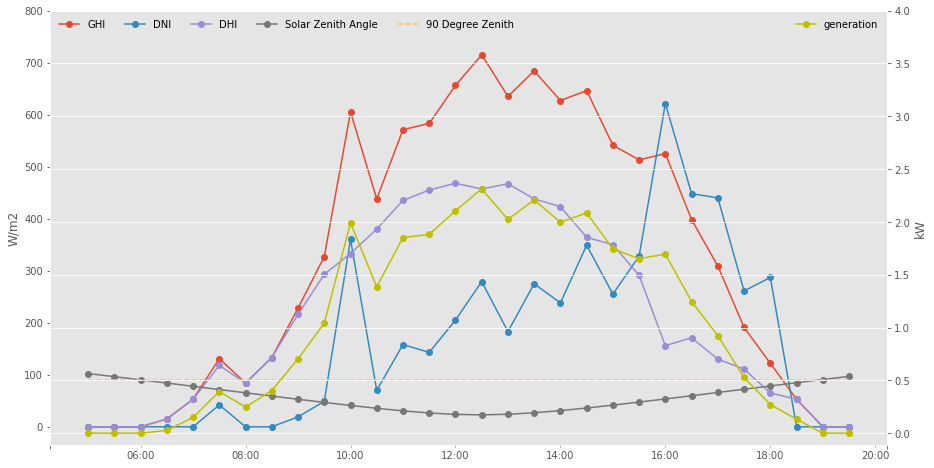

In [23]:
nsrdb_plot(df, 5050)